In [1]:

import timeit
from tqdm import tqdm
import re
import sympy as sp
import vector
import math
import numpy as np
import awkward as ak
import uproot as ut
import git
import sys
import os
%load_ext autoreload
%autoreload 2


sys.path.append(git.Repo('.', search_parent_directories=True).working_tree_dir)
from utils import *

In [2]:
fname = "/eos/uscms/store/user/ekoenig/6BAnalysis/NTuples/2018/SR/NN_Higgs/NMSSM/NMSSM_XYH_YToHH_6b_MX_700_MY_400_10M/output/ntuple_{nf}.root"
tree = Tree([ fname.format(nf=nf) for nf in range(1) ])


In [3]:
tree.extend(nn6j_eff=tree.nfound_nn/tree.nfound_presel,nbkg_jets=tree.n_jet-tree.nfound_presel)

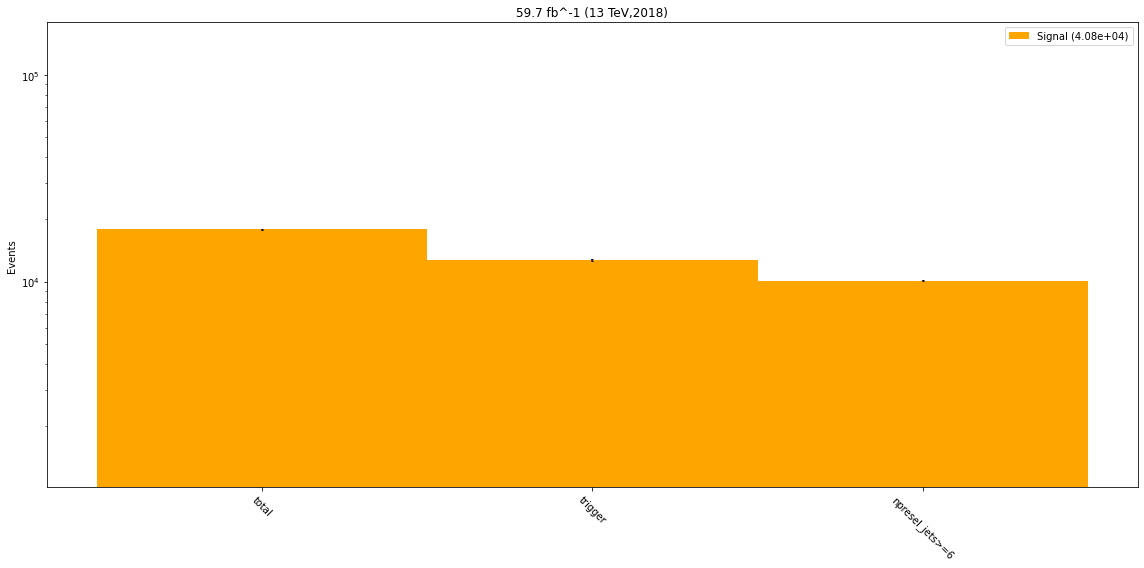

In [4]:
study.cutflow([tree])

# Prep Features


In [5]:
jets = get_collection(tree, 'jet', named=False)
jets = reorder_collection(jets,ak.argsort(-jets.pt,axis=-1))

In [8]:
lstm3d.feature_names = ['E','m','pt','eta','phi','btag']

In [172]:
features = lstm3d.get_features(jets)
target = lstm3d.get_target(jets)

In [176]:
scaled_features = lstm3d.scale_features(features)


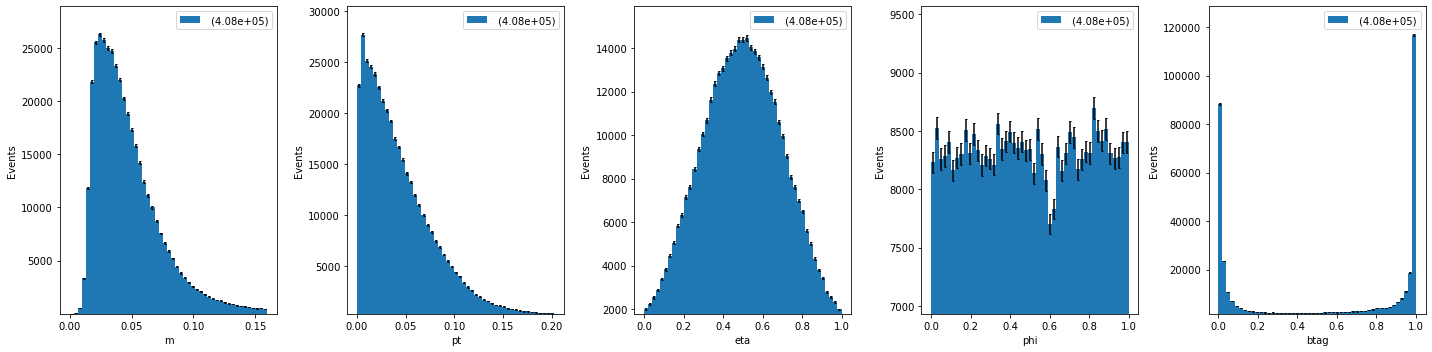

In [177]:
fig, axs = plt.subplots(nrows=1, ncols=len(features.fields), figsize=(20, 5))
for i, field in enumerate(scaled_features.fields):
    hist_multi([scaled_features[field]],
               xlabel=field, figax=(fig, axs.flat[i]))
fig.tight_layout()

In [178]:
features,target, maxjets, nfeatures, maskint = lstm3d.reshape_features(scaled_features,target)

# Build NN


In [180]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [181]:
r_X_train, r_X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, shuffle=True)


In [182]:
y_train.shape

(44733, 15, 4)

In [193]:
model = keras.models.Sequential()

model.add(layers.Masking(mask_value=maskint, input_shape=(None, nfeatures)))
model.add(layers.LSTM(240, return_sequences=True))
model.add(layers.LSTM(120, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(60, activation='relu')))
model.add(layers.TimeDistributed(layers.Dense(60, activation='relu')))

model.add(layers.LSTM(240, return_sequences=True))
model.add(layers.LSTM(120, return_sequences=True))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dense(60, activation='relu'))

model.add(layers.Dense(4, activation='softmax'))

model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_4 (Masking)          (None, None, 5)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, None, 240)         236160    
_________________________________________________________________
lstm_17 (LSTM)               (None, None, 120)         173280    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 60)          7260      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 60)          3660      
_________________________________________________________________
lstm_18 (LSTM)               (None, None, 240)         288960    
_________________________________________________________________
lstm_19 (LSTM)               (None, None, 120)        

In [194]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])


In [195]:
history = model.fit(
    r_X_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=100,
    verbose=1
)


Epoch 1/5
403/403 [==============================] - 150s 332ms/step - loss: 0.2203 - accuracy: 0.5180 - val_loss: 0.2040 - val_accuracy: 0.5596
Epoch 2/5
403/403 [==============================] - 131s 324ms/step - loss: 0.2006 - accuracy: 0.5617 - val_loss: 0.2013 - val_accuracy: 0.5616
Epoch 3/5
403/403 [==============================] - 126s 314ms/step - loss: 0.1998 - accuracy: 0.5630 - val_loss: 0.2021 - val_accuracy: 0.5606
Epoch 4/5
403/403 [==============================] - 119s 295ms/step - loss: 0.1993 - accuracy: 0.5642 - val_loss: 0.1994 - val_accuracy: 0.5632
Epoch 5/5
403/403 [==============================] - 114s 282ms/step - loss: 0.1986 - accuracy: 0.5633 - val_loss: 0.1984 - val_accuracy: 0.5646


In [ ]:
y_pred = model.predict(r_X_test)

In [ ]:
y_ak,y_pred_ak = lstm6j.jet_reshape(y_test,y_pred,maskint)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='NN Score', ylabel='Events'>)

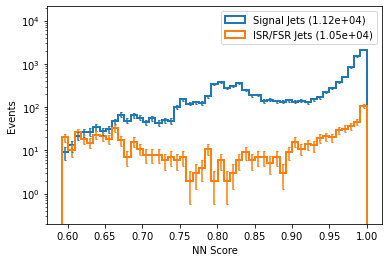

In [29]:
sig_scores = ak.mean(y_pred_ak[(y_ak == 1)],axis=-1)
bkg_scores = ak.mean(y_pred_ak[(y_ak == 0)],axis=-1)

hist_multi([sig_scores,bkg_scores],labels=["Signal Jets","ISR/FSR Jets"],xlabel="NN Score",log=1,density=0)

In [30]:
nsig = ak.sum(y_ak,axis=-1)
nsig_pred = ak.sum(y_ak[ak.argsort(-y_pred_ak,axis=-1)[:,:6]],axis=-1)
fig = plot_efficiency(nsig_pred,nsig)

study.save_fig(fig,'',saveas='rnn-eff')

NameError: name 'plot_efficiency' is not defined

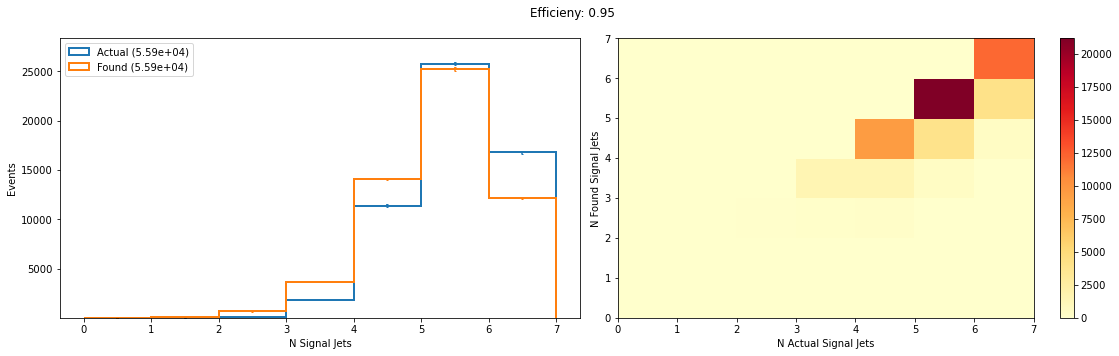

In [22]:
fig = plot_6j_efficiency(tree.nfound_nn,tree.nfound_presel)
study.save_fig(fig,'','dnn-eff')

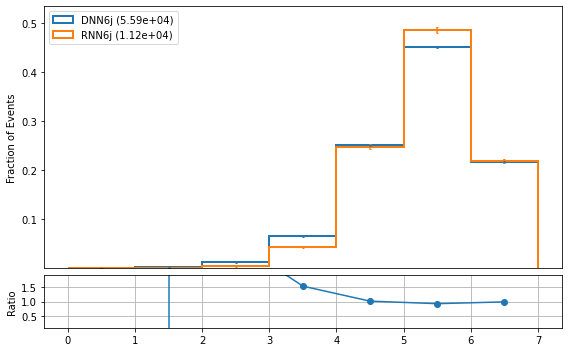

In [23]:
fig,ax = plt.subplots(figsize=(8,5))
hist_multi([tree.nfound_nn,nsig_pred],bins=range(8),density=1,ratio=1,labels=["DNN6j","RNN6j"],figax=(fig,ax))
fig.tight_layout()
study.save_fig(fig,'','rnn-dnn')

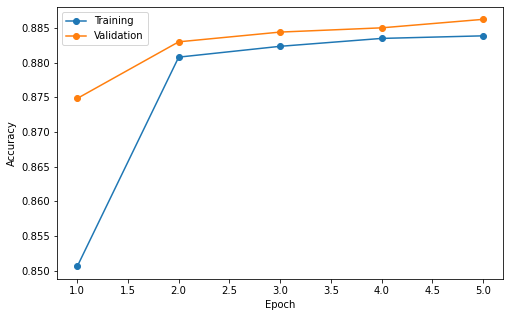

In [26]:
fig,ax = plot_history(history,'accuracy')

study.save_fig(fig,'','rnn-loss')